# 020: The Wilson-Cowan Model

Modeling excitatory-inhibitory population dynamics and neural oscillations.

## Learning Objectives

By the end of this tutorial, you will be able to:

- Understand the Wilson-Cowan equations for E/I population dynamics
- Explain the sigmoidal transfer function and its biological interpretation
- Analyze nullclines and fixed points in phase space
- Compute Jacobian matrices and classify stability via eigenvalues
- Demonstrate bistability and map basins of attraction
- Analyze bifurcation diagrams across 1D and 2D parameter spaces
- Characterize input-driven transient responses (pulse, step, ramp)
- Compare model variants and select appropriate formulations for specific applications
- Build whole-brain networks using structural connectivity and delays
- Interpret parameters as interpretable biological "knobs"

## Background / Theory

### The Wilson-Cowan Model

The **Wilson-Cowan model** (1972) is a foundational neural mass model describing the interaction between excitatory (E) and inhibitory (I) neural populations. It was one of the first models to capture emergent oscillatory dynamics from E/I balance.

### The Equations

$$
\begin{aligned}
\tau_E \frac{dr_E}{dt} &= -r_E + (1 - r \cdot r_E) \cdot F_E(w_{EE} r_E - w_{EI} r_I + I_E) \\
\tau_I \frac{dr_I}{dt} &= -r_I + (1 - r \cdot r_I) \cdot F_I(w_{IE} r_E - w_{II} r_I + I_I)
\end{aligned}
$$

where:
- $r_E, r_I$: Excitatory and inhibitory population activities
- $\tau_E, \tau_I$: Time constants
- $w_{XY}$: Connection weights from population Y to X
- $r$: Refractory parameter (limits maximum firing)
- $I_E, I_I$: External inputs

### The Sigmoid Transfer Function

$$
F(x; a, \theta) = \frac{1}{1 + e^{-a(x - \theta)}} - \frac{1}{1 + e^{a\theta}}
$$

| Parameter | Role |
|-----------|------|
| $a$ | Gain (steepness of response) |
| $\theta$ | Threshold (input level for half-activation) |

### Connection Weights

| Weight | Meaning | Typical Effect |
|--------|---------|----------------|
| $w_{EE}$ | E→E recurrence | Positive feedback, bistability |
| $w_{EI}$ | I→E inhibition | Negative feedback, stabilization |
| $w_{IE}$ | E→I excitation | Drives inhibition |
| $w_{II}$ | I→I recurrence | Self-inhibition |

### Dynamical Regimes

The Wilson-Cowan model exhibits rich dynamics:

1. **Stable fixed points**: E/I balance at rest
2. **Limit cycle oscillations**: Rhythmic E/I alternation
3. **Bistability**: Multiple stable states
4. **Excitable dynamics**: Transient responses to perturbations

### Parameter "Knobs" - Biological Interpretation

Each parameter in the Wilson-Cowan model corresponds to a biological or functional "knob" that can be tuned to produce different neural dynamics. Understanding these mappings is crucial for relating model behavior to neuroscience.

#### Individual Parameters

| Parameter | Knob Name | Biological Correspondence | Effect Range |
|-----------|-----------|---------------------------|--------------|
| $\tau_E, \tau_I$ | Response Speed | Membrane time constant, ion channel kinetics | Fast (1ms) → Slow (10ms) |
| $a_E, a_I$ | Neural Gain | Synaptic efficacy, neurotransmitter sensitivity | 0.5 (sluggish) → 2.0 (sensitive) |
| $\theta_E, \theta_I$ | Activation Threshold | Firing threshold voltage | 1.0 (easy to activate) → 5.0 (hard to activate) |
| $w_{EE}$ | Recurrent Excitation | AMPA/NMDA strength within E population | 0-20 |
| $w_{EI}$ | Feedback Inhibition | GABAergic strength I→E | 0-20 |
| $w_{IE}$ | Feedforward Excitation | Glutamatergic drive to inhibition | 0-10 |
| $w_{II}$ | Recurrent Inhibition | GABAergic self-inhibition within I | 0-15 |
| $r$ | Refractory Period | Sodium channel inactivation | 0 (none) → 2 (strong) |

#### Functional "Composite Knobs"

These combinations of parameters control higher-level system properties:

**1. E/I Balance Knob** ($w_{EE} / w_{EI}$ ratio):
- **High ratio (>1.0)**: Excitation-dominant system, risk of runaway activity (epileptiform)
- **Balanced (~0.9)**: Stable limit-cycle oscillations (gamma rhythms)
- **Low ratio (<0.8)**: Over-stabilized system, suppressed dynamics

**2. Timescale Separation Knob** ($\tau_I / \tau_E$):
- **$\tau_I \gg \tau_E$**: Slow inhibition relative to excitation → beta/gamma rhythms
- **$\tau_I \approx \tau_E$**: Symmetric dynamics → alpha rhythms
- **$\tau_I \ll \tau_E$**: Fast inhibition → high-frequency filtering

**3. Excitability Knob** ($a_E, \theta_E$):
- **High $a_E$, low $\theta_E$**: Hyperexcitable regime (epilepsy models)
- **Low $a_E$, high $\theta_E$**: Hypoexcitable regime (anesthesia models)
- **Intermediate**: Normal awake cortical states

These "knobs" provide an intuitive interface for parameter exploration while maintaining biological interpretability.

---

Now that we understand what the parameters mean biologically, let's implement the model and systematically explore its dynamics, building from simple phenomena to complex behaviors.

## Implementation

### Step 1: Setup and Imports

In [1]:
import brainstate
import braintools
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

import brainmass

# Set simulation time step
brainstate.environ.set(dt=0.1 * u.ms)

### Step 2: Single Node Simulation

Create a Wilson-Cowan oscillator with noise on both E and I populations:

In [2]:
# Create Wilson-Cowan node with OU noise
node = brainmass.WilsonCowanStep(
    1,  # single node
    noise_E=brainmass.OUProcess(1, sigma=0.01, tau=5.0 * u.ms),
    noise_I=brainmass.OUProcess(1, sigma=0.01, tau=5.0 * u.ms),
)

# Initialize states
node.init_all_states()

# Print default parameters
print("Default Wilson-Cowan parameters:")
print(f"  wEE = {node.wEE.value()}, wEI = {node.wEI.value()}")
print(f"  wIE = {node.wIE.value()}, wII = {node.wII.value()}")
print(f"  tau_E = {node.tau_E.value()}, tau_I = {node.tau_I.value()}")

Default Wilson-Cowan parameters:
  wEE = 12.0, wEI = 13.0
  wIE = 4.0, wII = 11.0
  tau_E = 1.0 * msecond, tau_I = 1.0 * msecond


In [3]:
# Define simulation step
def step_run(i):
    node.update(rE_inp=0.1)  # constant excitatory drive
    return node.rE.value, node.rI.value


# Run simulation (1000 ms)
indices = np.arange(10000)
rE_trace, rI_trace = brainstate.transform.for_loop(step_run, indices)

### Step 3: Visualize E/I Dynamics

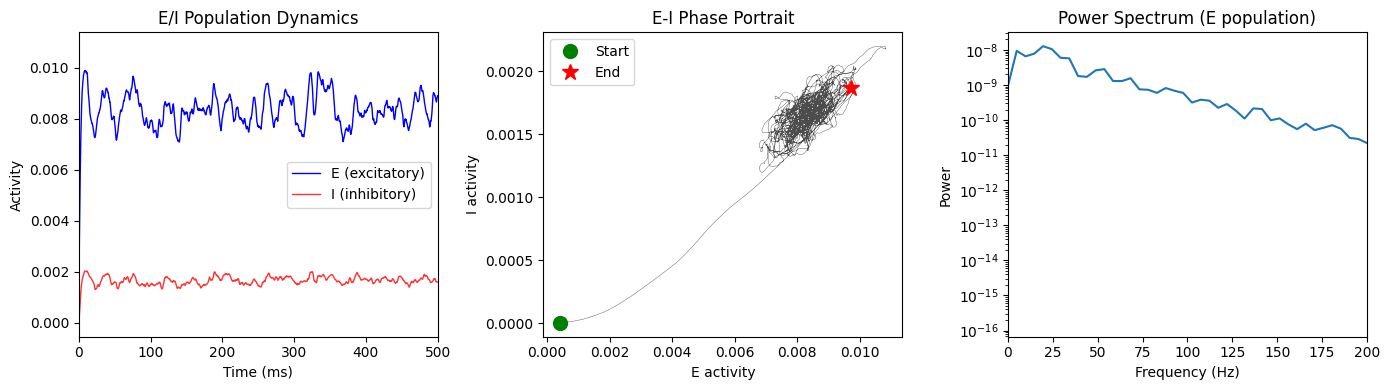

In [4]:
t_ms = indices * brainstate.environ.get_dt()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Time series
axes[0].plot(t_ms, rE_trace[:, 0], 'b-', label='E (excitatory)', linewidth=1)
axes[0].plot(t_ms, rI_trace[:, 0], 'r-', label='I (inhibitory)', linewidth=1, alpha=0.8)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Activity')
axes[0].set_title('E/I Population Dynamics')
axes[0].legend()
axes[0].set_xlim([0, 500])

# Phase portrait
axes[1].plot(rE_trace[:, 0], rI_trace[:, 0], 'k-', linewidth=0.3, alpha=0.7)
axes[1].plot(rE_trace[0, 0], rI_trace[0, 0], 'go', markersize=10, label='Start')
axes[1].plot(rE_trace[-1, 0], rI_trace[-1, 0], 'r*', markersize=12, label='End')
axes[1].set_xlabel('E activity')
axes[1].set_ylabel('I activity')
axes[1].set_title('E-I Phase Portrait')
axes[1].legend()

# Power spectrum
from scipy import signal

fs = 1000 / float(brainstate.environ.get_dt() / u.ms)  # sampling frequency
f, Pxx = signal.welch(rE_trace[2000:, 0], fs=fs, nperseg=2048)
axes[2].semilogy(f, Pxx)
axes[2].set_xlabel('Frequency (Hz)')
axes[2].set_ylabel('Power')
axes[2].set_title('Power Spectrum (E population)')
axes[2].set_xlim([0, 200])

plt.tight_layout()
plt.show()

### Step 3: Nullcline Analysis

We've seen that the model oscillates, but where are the equilibrium points? **Nullcline analysis** reveals the fixed points and flow structure in phase space.

Understanding the fixed points through nullcline intersection:

In [ ]:
# Sigmoid function
def F(x, a, theta):
    return 1 / (1 + np.exp(-a * (x - theta))) - 1 / (1 + np.exp(a * theta))


# Parameters (default values)
wEE, wEI, wIE, wII = 12., 13., 4., 11.
a_E, theta_E = 1.2, 2.8
a_I, theta_I = 1.0, 4.0
r = 1.0
I_E = 0.5  # external input

# Create grid
rE_range = np.linspace(-1, 1, 200)
rI_range = np.linspace(-1, 1, 200)
RE, RI = np.meshgrid(rE_range, rI_range)

# E-nullcline: drE/dt = 0
# rE = (1 - r*rE) * F(wEE*rE - wEI*rI + I_E)
# Solve numerically by finding where drE/dt changes sign
drE = -RE + (1 - r * RE) * F(wEE * RE - wEI * RI + I_E, a_E, theta_E)
drI = -RI + (1 - r * RI) * F(wIE * RE - wII * RI, a_I, theta_I)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

# Plot nullclines
ax.contour(RE, RI, drE, levels=[0], colors=['blue'], linewidths=2)
ax.contour(RE, RI, drI, levels=[0], colors=['red'], linewidths=2)

# Vector field
skip = 10
ax.quiver(
    RE[::skip, ::skip],
    RI[::skip, ::skip],
    drE[::skip, ::skip],
    drI[::skip, ::skip],
    alpha=0.5
)

# Overlay trajectory
ax.plot(rE_trace[:, 0], rI_trace[:, 0], 'k-', linewidth=0.5, alpha=0.7, label='Trajectory')

ax.set_xlabel('E activity (rE)')
ax.set_ylabel('I activity (rI)')
ax.set_title('Nullclines and Phase Flow')

# Legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='blue', linewidth=2, label='E-nullcline'),
    Line2D([0], [0], color='red', linewidth=2, label='I-nullcline'),
    Line2D([0], [0], color='black', linewidth=1, label='Trajectory')
]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

### Step 4: Fixed Point Stability Analysis

While nullcline analysis shows us *where* fixed points exist, **linear stability analysis** tells us whether they are stable (attracting) or unstable (repelling). This requires computing the **Jacobian matrix** and its **eigenvalues**.

#### Theory Recap

At a fixed point $(r_E^*, r_I^*)$, we linearize the system:

$$
\frac{d}{dt}\begin{pmatrix} \delta r_E \\ \delta r_I \end{pmatrix} = \mathbf{J} \begin{pmatrix} \delta r_E \\ \delta r_I \end{pmatrix}
$$

where the Jacobian matrix is:

$$
\mathbf{J} = \begin{pmatrix}
\frac{\partial}{\partial r_E}\left(\frac{dr_E}{dt}\right) & \frac{\partial}{\partial r_I}\left(\frac{dr_E}{dt}\right) \\
\frac{\partial}{\partial r_E}\left(\frac{dr_I}{dt}\right) & \frac{\partial}{\partial r_I}\left(\frac{dr_I}{dt}\right)
\end{pmatrix}_{\text{at } (r_E^*, r_I^*)}
$$

The eigenvalues $\lambda_1, \lambda_2$ of $\mathbf{J}$ determine stability:
- **All $\text{Re}(\lambda) < 0$**: Stable fixed point
- **Any $\text{Re}(\lambda) > 0$**: Unstable fixed point
- **$\text{Im}(\lambda) \neq 0$**: Spiraling trajectories

In [10]:
from scipy.optimize import fsolve


# Sigmoid derivative: dF/dx = a * F * (1 - F_normalized)
def dF(x, a, theta):
    """Derivative of sigmoid transfer function"""
    exp_term = np.exp(-a * (x - theta))
    base_sigmoid = 1 / (1 + exp_term)
    return a * base_sigmoid * (1 - base_sigmoid)


# System parameters
class WCParams:
    """Container for Wilson-Cowan parameters"""

    def __init__(self):
        self.tau_E = 1.0
        self.tau_I = 1.0
        self.a_E = 1.2
        self.a_I = 1.0
        self.theta_E = 2.8
        self.theta_I = 4.0
        self.wEE = 12.0
        self.wEI = 13.0
        self.wIE = 4.0
        self.wII = 11.0
        self.r = 1.0


params = WCParams()


def system_rhs(state, I_E):
    """Right-hand side of Wilson-Cowan ODEs"""
    rE, rI = state

    # Excitatory input
    input_E = params.wEE * rE - params.wEI * rI + I_E
    input_I = params.wIE * rE - params.wII * rI

    # Dynamics
    drE_dt = (-rE + (1 - params.r * rE) * F(input_E, params.a_E, params.theta_E)) / params.tau_E
    drI_dt = (-rI + (1 - params.r * rI) * F(input_I, params.a_I, params.theta_I)) / params.tau_I

    return [drE_dt, drI_dt]


def jacobian_matrix(rE_fp, rI_fp, I_E):
    """
    Compute Jacobian matrix at fixed point (rE_fp, rI_fp)
    
    Returns 2x2 matrix of partial derivatives
    """
    # Inputs at fixed point
    input_E = params.wEE * rE_fp - params.wEI * rI_fp + I_E
    input_I = params.wIE * rE_fp - params.wII * rI_fp

    # Sigmoid values
    F_E = F(input_E, params.a_E, params.theta_E)
    F_I = F(input_I, params.a_I, params.theta_I)

    # Sigmoid derivatives
    dF_E = dF(input_E, params.a_E, params.theta_E)
    dF_I = dF(input_I, params.a_I, params.theta_I)

    # Jacobian elements (chain rule carefully applied)
    # J11 = ∂(drE/dt)/∂rE
    J11 = (-1 + (1 - params.r * rE_fp) * dF_E * params.wEE - params.r * F_E) / params.tau_E

    # J12 = ∂(drE/dt)/∂rI
    J12 = ((1 - params.r * rE_fp) * dF_E * (-params.wEI)) / params.tau_E

    # J21 = ∂(drI/dt)/∂rE
    J21 = ((1 - params.r * rI_fp) * dF_I * params.wIE) / params.tau_I

    # J22 = ∂(drI/dt)/∂rI
    J22 = (-1 + (1 - params.r * rI_fp) * dF_I * (-params.wII) - params.r * F_I) / params.tau_I

    return np.array([[J11, J12], [J21, J22]])


def classify_stability(eigenvalues):
    """Classify fixed point based on eigenvalues"""
    real_parts = np.real(eigenvalues)
    imag_parts = np.imag(eigenvalues)

    if all(real_parts < 0):
        if all(abs(imag_parts) < 1e-6):
            return "Stable node", "green"
        else:
            return "Stable spiral", "green"
    elif any(real_parts > 0):
        if all(abs(imag_parts) < 1e-6):
            return "Saddle point", "orange"
        else:
            return "Unstable spiral", "red"
    else:
        return "Center (marginally stable)", "yellow"


# Analyze fixed points for different external inputs
I_E_values = [0.0, 0.5, 1.0, 1.5]
fixed_points = []
jacobians = []
eigenvalue_list = []
stability_types = []
colors = []

print("Fixed Point Stability Analysis:")
print("=" * 60)

for I_E in I_E_values:
    # Find fixed point
    initial_guess = [0.3, 0.2]
    fp = fsolve(system_rhs, initial_guess, args=(I_E,))

    # Compute Jacobian
    J = jacobian_matrix(fp[0], fp[1], I_E)

    # Eigenvalues
    eigs = np.linalg.eigvals(J)

    # Classify
    stability, color = classify_stability(eigs)

    # Store results
    fixed_points.append(fp)
    jacobians.append(J)
    eigenvalue_list.append(eigs)
    stability_types.append(stability)
    colors.append(color)

    print(f"I_E = {I_E:.1f}:")
    print(f"  Fixed point: rE = {fp[0]:.4f}, rI = {fp[1]:.4f}")
    print(f"  Eigenvalues: λ1 = {eigs[0]:.4f}, λ2 = {eigs[1]:.4f}")
    print(f"  Stability: {stability}")
    print()

Fixed Point Stability Analysis:
I_E = 0.0:
  Fixed point: rE = 0.0000, rI = 0.0000
  Eigenvalues: λ1 = -0.5922, λ2 = -1.1349
  Stability: Stable node

I_E = 0.5:
  Fixed point: rE = 0.0440, rI = 0.0116
  Eigenvalues: λ1 = 0.0014, λ2 = -1.1274
  Stability: Saddle point

I_E = 1.0:
  Fixed point: rE = 0.0186, rI = 0.0304
  Eigenvalues: λ1 = 0.0006, λ2 = -1.0865
  Stability: Saddle point

I_E = 1.5:
  Fixed point: rE = -0.0053, rI = 0.0501
  Eigenvalues: λ1 = -0.0023, λ2 = -1.0567
  Stability: Stable node



C:\Users\adadu\AppData\Local\Temp\ipykernel_28108\178428597.py:115: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last five Jacobian evaluations.
  fp = fsolve(system_rhs, initial_guess, args=(I_E,))
C:\Users\adadu\AppData\Local\Temp\ipykernel_28108\178428597.py:115: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  fp = fsolve(system_rhs, initial_guess, args=(I_E,))


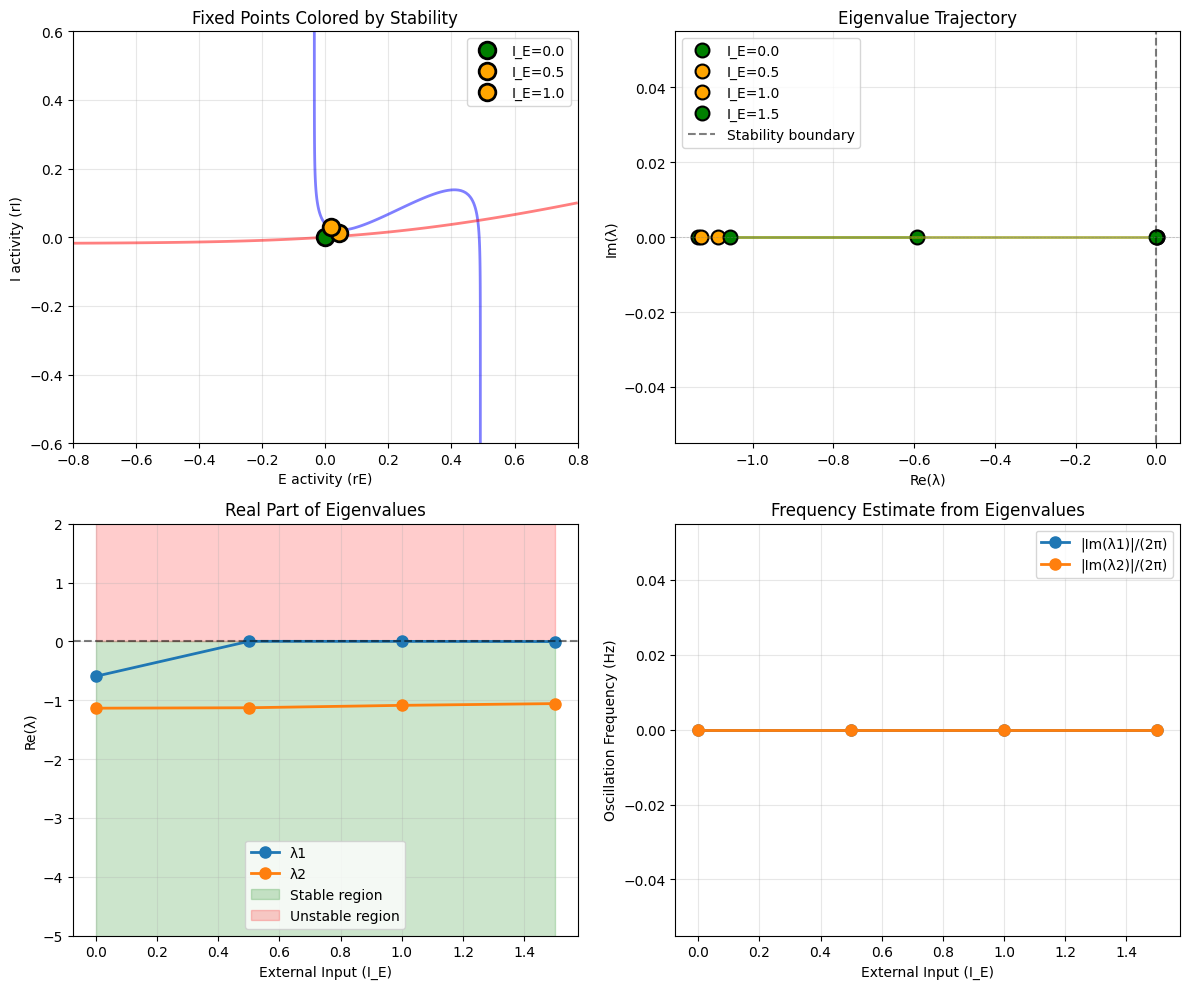


Interpretation:
- Green points: Stable fixed points (attracting)
- Red points: Unstable fixed points (repelling, may have limit cycle nearby)
- Orange points: Saddle points (unstable but not uniformly repelling)
- Eigenvalues crossing from Re(λ) < 0 to Re(λ) > 0 indicate a Hopf bifurcation


In [12]:
# Visualization: Fixed points and eigenvalue trajectories
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Panel 1: Phase portrait with fixed points colored by stability
ax = axes[0, 0]
rE_range = np.linspace(-0.8, 0.8, 200)
rI_range = np.linspace(-0.6, 0.6, 200)
RE, RI = np.meshgrid(rE_range, rI_range)

# Recompute nullclines for I_E = 0.5
I_E_plot = 0.5
drE = -RE + (1 - params.r * RE) * F(params.wEE * RE - params.wEI * RI + I_E_plot, params.a_E, params.theta_E)
drI = -RI + (1 - params.r * RI) * F(params.wIE * RE - params.wII * RI, params.a_I, params.theta_I)

ax.contour(RE, RI, drE, levels=[0], colors=['blue'], linewidths=2, alpha=0.5)
ax.contour(RE, RI, drI, levels=[0], colors=['red'], linewidths=2, alpha=0.5)

# Plot fixed points
for i, (fp, color, stab) in enumerate(zip(fixed_points, colors, stability_types)):
    if i < len(I_E_values) - 1:  # Skip last one for cleaner plot
        ax.plot(
            fp[0],
            fp[1],
            'o',
            markersize=12,
            color=color,
            markeredgecolor='black',
            markeredgewidth=2,
            label=f'I_E={I_E_values[i]:.1f}'
        )

ax.set_xlabel('E activity (rE)')
ax.set_ylabel('I activity (rI)')
ax.set_title('Fixed Points Colored by Stability')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Eigenvalue trajectory in complex plane
ax = axes[0, 1]
for i, (eigs, I_E, color) in enumerate(zip(eigenvalue_list, I_E_values, colors)):
    ax.plot(
        np.real(eigs),
        np.imag(eigs),
        'o',
        markersize=10,
        color=color,
        markeredgecolor='black',
        markeredgewidth=1.5,
        label=f'I_E={I_E:.1f}'
    )

    # Connect eigenvalues with a line
    if len(eigs) == 2:
        ax.plot(
            [np.real(eigs[0]), np.real(eigs[1])],
            [np.imag(eigs[0]), np.imag(eigs[1])],
            '-',
            color=color,
            alpha=0.3,
            linewidth=2
        )

# Stability boundaries
ax.axvline(x=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5, label='Stability boundary')
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.set_xlabel('Re(λ)')
ax.set_ylabel('Im(λ)')
ax.set_title('Eigenvalue Trajectory')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Real parts of eigenvalues vs I_E
ax = axes[1, 0]
real_parts = np.array([[np.real(eig) for eig in eigs] for eigs in eigenvalue_list])
for j in range(2):
    ax.plot(I_E_values, real_parts[:, j], 'o-', markersize=8, linewidth=2, label=f'λ{j + 1}')
ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.5)
ax.fill_between(I_E_values, -10, 0, alpha=0.2, color='green', label='Stable region')
ax.fill_between(I_E_values, 0, 10, alpha=0.2, color='red', label='Unstable region')
ax.set_xlabel('External Input (I_E)')
ax.set_ylabel('Re(λ)')
ax.set_title('Real Part of Eigenvalues')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([-5, 2])

# Panel 4: Imaginary parts (oscillation frequency indicator)
ax = axes[1, 1]
imag_parts = np.array([[np.imag(eig) for eig in eigs] for eigs in eigenvalue_list])
freq_estimate = np.abs(imag_parts) / (2 * np.pi)  # Convert to Hz
for j in range(2):
    ax.plot(I_E_values, freq_estimate[:, j], 'o-', markersize=8, linewidth=2, label=f'|Im(λ{j + 1})|/(2π)')
ax.set_xlabel('External Input (I_E)')
ax.set_ylabel('Oscillation Frequency (Hz)')
ax.set_title('Frequency Estimate from Eigenvalues')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("- Green points: Stable fixed points (attracting)")
print("- Red points: Unstable fixed points (repelling, may have limit cycle nearby)")
print("- Orange points: Saddle points (unstable but not uniformly repelling)")
print("- Eigenvalues crossing from Re(λ) < 0 to Re(λ) > 0 indicate a Hopf bifurcation")

---

Fixed points show where the system wants to go. Now let's examine **how** it gets there by studying transient responses to different input types.

### Step 5: Input-Driven Transient Response

Neural systems must respond to external stimuli. The **transient response** characterizes how the system reacts to inputs of different profiles:

1. **Pulse Input**: Brief stimulation (e.g., sensory flash) → tests **excitability**
2. **Step Input**: Sustained drive onset (e.g., attention signal) → tests **adaptation**
3. **Ramp Input**: Gradually increasing signal (e.g., accumulating evidence) → tests **tracking**

These response patterns reveal:
- **Latency**: How quickly the system responds
- **Gain**: Amplitude of response relative to input
- **Damping**: Whether oscillations persist or decay
- **Steady-state error**: Difference between input and equilibrium response

In [14]:
# Define input functions
def pulse_input(t):
    """Brief 10ms pulse at t=100ms"""
    return u.math.where(
        u.math.logical_and(t > 100. * u.ms, t < 110. * u.ms),
        2.0,
        0.0
    )


def step_input(t):
    """Step increase at t=200ms"""
    return u.math.where(
        t > 200. * u.ms,
        1.0,
        0.0,
    )


def ramp_input(t):
    """Ramp from 0 to 2.0 over 500ms"""
    return u.math.where(
        t > 0. * u.ms,
        u.math.minimum(t / (500. * u.ms), 2.0),
        0.0
    )


# Input types to test
input_functions = [pulse_input, step_input, ramp_input]
input_names = ['Pulse (10ms)', 'Step (at 200ms)', 'Ramp (500ms)']
input_colors = ['purple', 'orange', 'green']

# Simulate each input type
responses_E = []
responses_I = []
input_traces = []

print("Simulating input-driven responses...")

for input_func, name in zip(input_functions, input_names):
    # Create fresh model
    model_transient = brainmass.WilsonCowanStep(1)
    model_transient.init_all_states()


    def step_transient(i):
        t = i * brainstate.environ.get_dt()
        inp = input_func(t)
        model_transient.update(rE_inp=inp)
        return model_transient.rE.value, model_transient.rI.value, inp


    indices_trans = np.arange(6000)  # 600 ms
    rE_resp, rI_resp, inp_trace = brainstate.transform.for_loop(step_transient, indices_trans)

    responses_E.append(rE_resp)
    responses_I.append(rI_resp)
    input_traces.append(inp_trace)

    print(f"  {name}: Complete")

print("Done!")

Simulating input-driven responses...
  Pulse (10ms): Complete
  Step (at 200ms): Complete
  Ramp (500ms): Complete
Done!


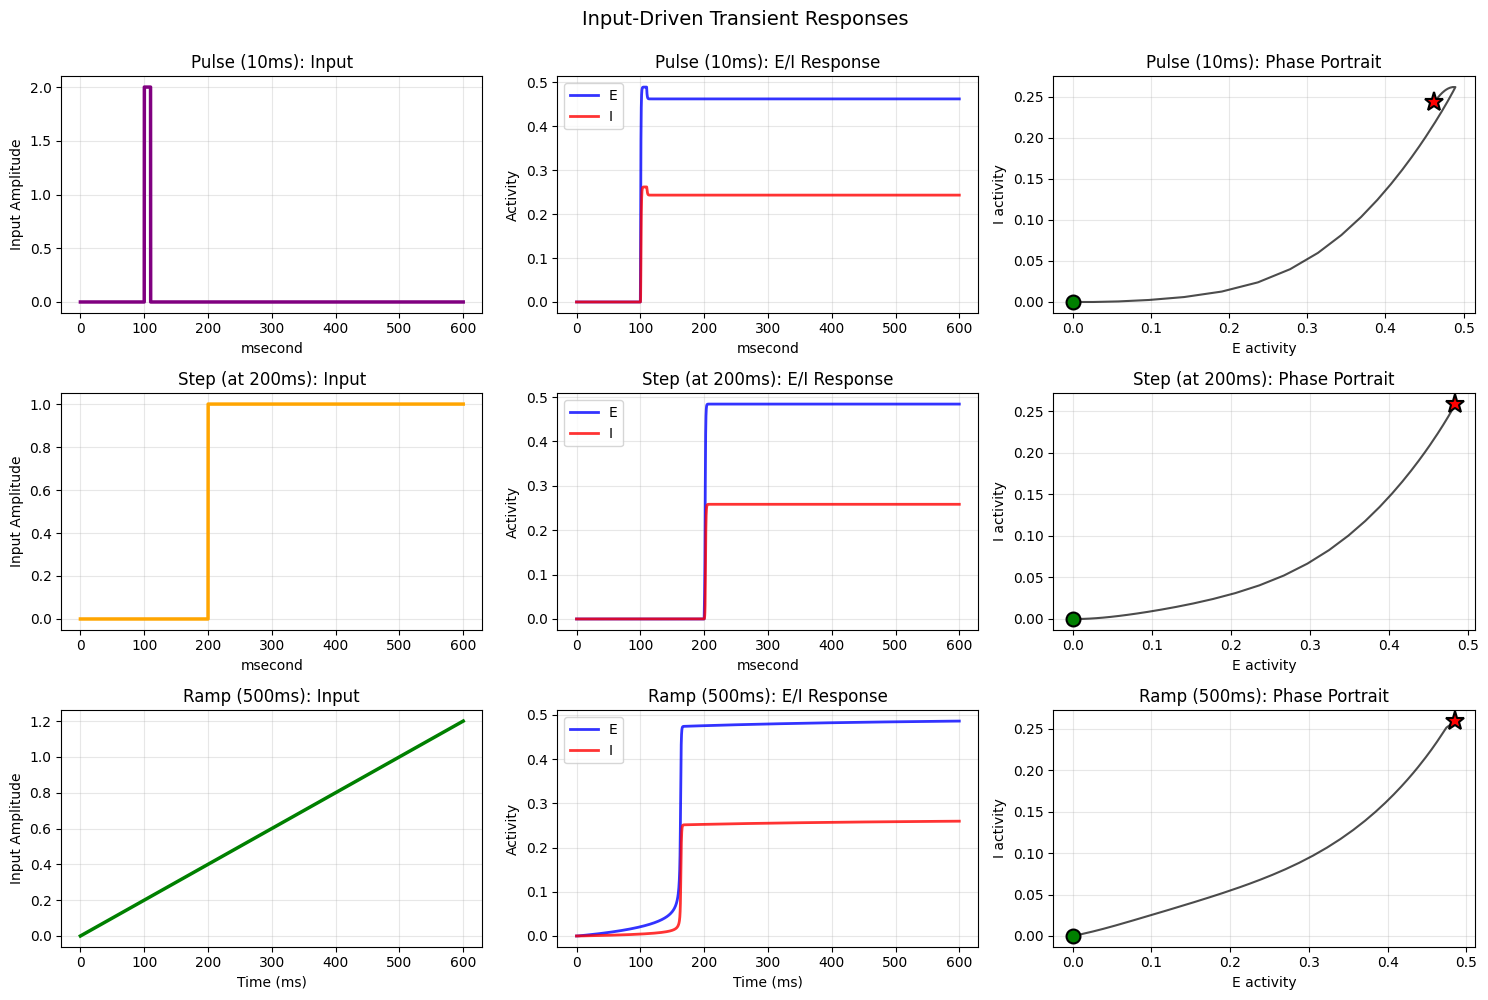


Response Metrics:
Pulse (10ms):
  Peak amplitude: 0.4894 at t=108.3 ms
  Response latency: 100.2 ms
  Steady state: 0.4625
  Overshoot: 5.8%

Step (at 200ms):
  Peak amplitude: 0.4843 at t=209.7 ms
  Response latency: 200.7 ms
  Steady state: 0.4843
  Overshoot: 0.0%

Ramp (500ms):
  Peak amplitude: 0.4859 at t=599.9 ms
  Response latency: 145.9 ms
  Steady state: 0.4858
  Overshoot: 0.0%



In [15]:
# Visualization: 3x3 grid (input type × measurement)
fig, axes = plt.subplots(3, 3, figsize=(15, 10))

t_trans = indices_trans * brainstate.environ.get_dt()

for row, (rE_resp, rI_resp, inp_trace, name, color) in enumerate(
    zip(responses_E, responses_I, input_traces, input_names, input_colors)
):

    # Column 1: Input trace
    ax = axes[row, 0]
    ax.plot(t_trans, inp_trace, color=color, linewidth=2.5)
    ax.set_ylabel('Input Amplitude')
    ax.set_title(f'{name}: Input')
    ax.grid(True, alpha=0.3)
    if row == 2:
        ax.set_xlabel('Time (ms)')

    # Column 2: E/I Response
    ax = axes[row, 1]
    ax.plot(t_trans, rE_resp[:, 0], 'b-', linewidth=2, label='E', alpha=0.8)
    ax.plot(t_trans, rI_resp[:, 0], 'r-', linewidth=2, label='I', alpha=0.8)
    ax.set_ylabel('Activity')
    ax.set_title(f'{name}: E/I Response')
    ax.legend()
    ax.grid(True, alpha=0.3)
    if row == 2:
        ax.set_xlabel('Time (ms)')

    # Column 3: Phase Portrait
    ax = axes[row, 2]
    ax.plot(rE_resp[:, 0], rI_resp[:, 0], 'k-', linewidth=1.5, alpha=0.7)
    ax.plot(rE_resp[0, 0], rI_resp[0, 0], 'go', markersize=10, markeredgecolor='black', markeredgewidth=1.5)
    ax.plot(rE_resp[-1, 0], rI_resp[-1, 0], 'r*', markersize=14, markeredgecolor='black', markeredgewidth=1.5)
    ax.set_xlabel('E activity')
    ax.set_ylabel('I activity')
    ax.set_title(f'{name}: Phase Portrait')
    ax.grid(True, alpha=0.3)

plt.suptitle('Input-Driven Transient Responses', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# Quantitative metrics
print("\nResponse Metrics:")
print("=" * 60)

for i, (rE_resp, name) in enumerate(zip(responses_E, input_names)):
    # Find peak
    peak_idx = np.argmax(rE_resp[:, 0])
    peak_time = float(t_trans[peak_idx] / u.ms)
    peak_amplitude = rE_resp[peak_idx, 0]

    # Steady state (last 100 samples)
    steady_state = np.mean(rE_resp[-100:, 0])

    # Initial response time (when crosses 10% of peak)
    threshold = 0.1 * peak_amplitude
    response_idx = np.where(rE_resp[:, 0] > threshold)[0]
    response_time = float(t_trans[response_idx[0]] / u.ms) if len(response_idx) > 0 else 0

    print(f"{name}:")
    print(f"  Peak amplitude: {peak_amplitude:.4f} at t={peak_time:.1f} ms")
    print(f"  Response latency: {response_time:.1f} ms")
    print(f"  Steady state: {steady_state:.4f}")
    print(f"  Overshoot: {(peak_amplitude - steady_state) / steady_state * 100:.1f}%")
    print()

---

We've explored how the system responds to brief perturbations. But what if multiple stable states coexist?

### Step 6: Bistability Demonstration

One of the most fascinating phenomena in neural dynamics is **bistability**: the coexistence of two stable states. Depending on the initial condition, the system can settle into different attractors, even with the same parameters and inputs.

This property is crucial for modeling:
- **Cortical up/down states** (transitions between high and low firing)
- **Working memory** (persistent activity states)
- **Decision-making** (commitment to one of two choices)

We'll demonstrate bistability by:
1. Finding parameter regime where two stable fixed points coexist
2. Showing trajectories from different initial conditions converge to different attractors
3. Computing the **basin of attraction** for each stable state

In [26]:
@brainstate.transform.jit(static_argnums=2, static_argnames='n_steps')
def bistable_simulation(rE0, rI0, n_steps: int = 20000):
    # Create model in bistable parameter regime
    # Key: High recurrent excitation (wEE) creates positive feedback
    model_bistable = brainmass.WilsonCowanStep(
        1,
        wEE=16.0,  # Increased from default 12
        wEI=12.0,  # Decreased from default 13
        wII=8.0,  # Decreased from default 11
    )

    # Reset and set initial condition
    model_bistable.init_all_states()
    model_bistable.rE.value = u.math.array([rE0])
    model_bistable.rI.value = u.math.array([rI0])

    # Simulate
    def step_bistable(i):
        model_bistable.update(rE_inp=0.5)  # Constant input
        return model_bistable.rE.value, model_bistable.rI.value

    indices_bistable = np.arange(n_steps)  # 2000 ms
    rE_traj, rI_traj = brainstate.transform.for_loop(step_bistable, indices_bistable)
    return rE_traj, rI_traj

In [27]:
# Different initial conditions
initial_conditions = [
    (0.05, 0.05),  # Low state
    (0.65, 0.35),  # High state
    (0.35, 0.20),  # Intermediate (will go to one or the other)
]

colors_ic = ['blue', 'red', 'purple']
labels_ic = ['Low IC', 'High IC', 'Mid IC']

# Storage for trajectories
trajectories_rE = []
trajectories_rI = []

print("Simulating bistability from different initial conditions...")

for (rE0, rI0), color, label in zip(initial_conditions, colors_ic, labels_ic):
    rE_traj, rI_traj = bistable_simulation(rE0, rI0, n_steps=20000)

    trajectories_rE.append(rE_traj)
    trajectories_rI.append(rI_traj)

    print(f"  {label}: "
          f"Started at ({rE0:.2f}, {rI0:.2f}), "
          f"ended at ({float(rE_traj[-1, 0]):.4f}, {float(rI_traj[-1, 0]):.4f})")

print("Done!")

Simulating bistability from different initial conditions...
  Low IC: Started at (0.05, 0.05), ended at (0.4902, 0.2812)
  High IC: Started at (0.65, 0.35), ended at (0.4902, 0.2812)
  Mid IC: Started at (0.35, 0.20), ended at (0.4902, 0.2812)
Done!


Computing basin of attraction (this may take ~30-60 seconds)...
Basin computation complete!


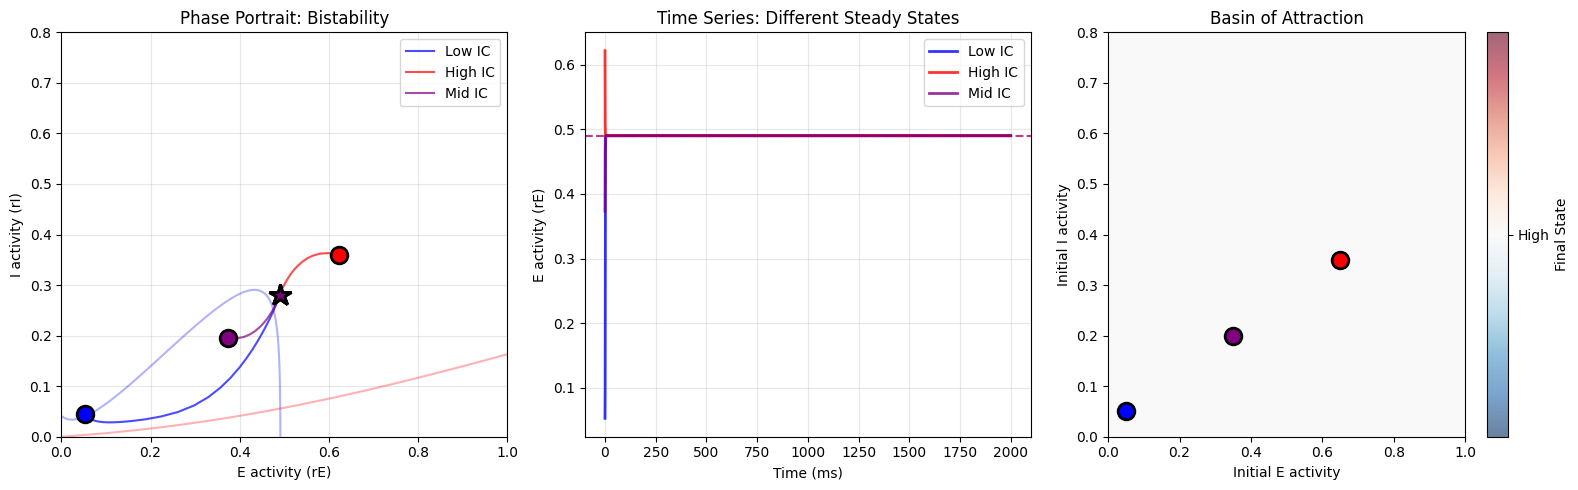


Biological Significance:
- Blue region → Low state (cortical 'down' state)
- Red region → High state (cortical 'up' state)
- Boundary separates the two basins of attraction


In [28]:
# Visualization: 3-panel bistability figure
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Panel 1: Phase portrait with trajectories
ax = axes[0]

# Plot nullclines for reference
rE_range_bis = np.linspace(0, 1, 200)
rI_range_bis = np.linspace(0, 0.8, 200)
RE_bis, RI_bis = np.meshgrid(rE_range_bis, rI_range_bis)

wEE_bis, wEI_bis = 16.0, 12.0
wIE_bis, wII_bis = 4.0, 8.0
I_E_bis = 0.5

drE_bis = -RE_bis + (1 - 1.0 * RE_bis) * F(wEE_bis * RE_bis - wEI_bis * RI_bis + I_E_bis, 1.2, 2.8)
drI_bis = -RI_bis + (1 - 1.0 * RI_bis) * F(wIE_bis * RE_bis - wII_bis * RI_bis, 1.0, 4.0)

ax.contour(RE_bis, RI_bis, drE_bis, levels=[0], colors=['blue'], linewidths=1.5, alpha=0.3)
ax.contour(RE_bis, RI_bis, drI_bis, levels=[0], colors=['red'], linewidths=1.5, alpha=0.3)

# Plot trajectories
for (rE_traj, rI_traj, color, label) in zip(trajectories_rE, trajectories_rI, colors_ic, labels_ic):
    ax.plot(rE_traj[:, 0], rI_traj[:, 0], '-', color=color, linewidth=1.5, alpha=0.7, label=label)
    ax.plot(rE_traj[0, 0], rI_traj[0, 0], 'o', color=color, markersize=12, markeredgecolor='black', markeredgewidth=2)
    ax.plot(rE_traj[-1, 0], rI_traj[-1, 0], '*', color=color, markersize=16, markeredgecolor='black', markeredgewidth=2)

ax.set_xlabel('E activity (rE)')
ax.set_ylabel('I activity (rI)')
ax.set_title('Phase Portrait: Bistability')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Time series overlay
ax = axes[1]
t_bis = indices_bistable * brainstate.environ.get_dt()

for (rE_traj, color, label) in zip(trajectories_rE, colors_ic, labels_ic):
    ax.plot(t_bis, rE_traj[:, 0], '-', color=color, linewidth=2, label=label, alpha=0.8)

ax.set_xlabel('Time (ms)')
ax.set_ylabel('E activity (rE)')
ax.set_title('Time Series: Different Steady States')
ax.legend()
ax.grid(True, alpha=0.3)
ax.axhline(y=trajectories_rE[0][-1, 0], color=colors_ic[0], linestyle='--', alpha=0.5)
ax.axhline(y=trajectories_rE[1][-1, 0], color=colors_ic[1], linestyle='--', alpha=0.5)

# Panel 3: Basin of attraction
ax = axes[2]

# Grid of initial conditions
rE_init_grid = np.linspace(0, 1, 40)
rI_init_grid = np.linspace(0, 0.8, 40)
basin_map = np.zeros((len(rI_init_grid), len(rE_init_grid)))

print("Computing basin of attraction (this may take ~30-60 seconds)...")

for i, rE_init in enumerate(rE_init_grid):
    for j, rI_init in enumerate(rI_init_grid):
        rE_final = bistable_simulation(rE_init, rI_init, n_steps=15000)[0]

        # Classify final state (low vs high)
        final_value = rE_final[-1, 0]
        if final_value < 0.3:
            basin_map[j, i] = 0  # Low state
        else:
            basin_map[j, i] = 1  # High state

print("Basin computation complete!")

# Plot basin
im = ax.imshow(basin_map, extent=[0, 1, 0, 0.8], origin='lower', cmap='RdBu_r', alpha=0.6, aspect='auto')
ax.set_xlabel('Initial E activity')
ax.set_ylabel('Initial I activity')
ax.set_title('Basin of Attraction')

# Mark the initial conditions we tested
for (rE0, rI0), color in zip(initial_conditions, colors_ic):
    ax.plot(rE0, rI0, 'o', color=color, markersize=12, markeredgecolor='black', markeredgewidth=2)

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0, 1])
cbar.set_label('Final State')
cbar.ax.set_yticklabels(['Low', 'High'])

plt.tight_layout()
plt.show()

print("\nBiological Significance:")
print("- Blue region → Low state (cortical 'down' state)")
print("- Red region → High state (cortical 'up' state)")
print("- Boundary separates the two basins of attraction")

---

We've thoroughly explored single-node dynamics. Now let's understand how parameters control these phenomena.

### Step 7: One-Parameter Bifurcation Analysis

Sweep external input to reveal oscillatory and fixed-point regimes across a single parameter dimension:

In [29]:
# Input values to sweep
exc_inputs = np.arange(0, 5.5, 0.05)

# Create nodes for all input values simultaneously
nodes = brainmass.WilsonCowanStep(exc_inputs.size)
nodes.init_all_states()


def step_sweep(i):
    return nodes.update(rE_inp=exc_inputs)


# Run simulation
indices = np.arange(15000)
rE_sweep = brainstate.transform.for_loop(step_sweep, indices)

# Discard transient and compute min/max
rE_steady = rE_sweep[5000:, :]
max_exc = rE_steady.max(axis=0)
min_exc = rE_steady.min(axis=0)

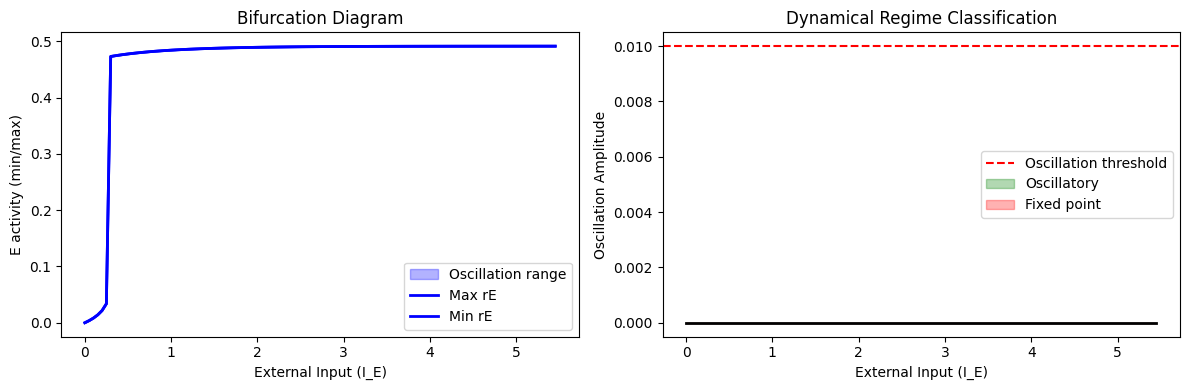

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bifurcation diagram
axes[0].fill_between(exc_inputs, min_exc, max_exc, alpha=0.3, color='blue', label='Oscillation range')
axes[0].plot(exc_inputs, max_exc, 'b-', linewidth=2, label='Max rE')
axes[0].plot(exc_inputs, min_exc, 'b-', linewidth=2, label='Min rE')
axes[0].set_xlabel('External Input (I_E)')
axes[0].set_ylabel('E activity (min/max)')
axes[0].set_title('Bifurcation Diagram')
axes[0].legend()

# Identify regimes
oscillation_amplitude = max_exc - min_exc
axes[1].plot(exc_inputs, oscillation_amplitude, 'k-', linewidth=2)
axes[1].axhline(0.01, color='r', linestyle='--', label='Oscillation threshold')
axes[1].fill_between(exc_inputs, 0, oscillation_amplitude,
                     where=oscillation_amplitude > 0.01, alpha=0.3, color='green', label='Oscillatory')
axes[1].fill_between(exc_inputs, 0, oscillation_amplitude,
                     where=oscillation_amplitude <= 0.01, alpha=0.3, color='red', label='Fixed point')
axes[1].set_xlabel('External Input (I_E)')
axes[1].set_ylabel('Oscillation Amplitude')
axes[1].set_title('Dynamical Regime Classification')
axes[1].legend()

plt.tight_layout()
plt.show()

# Find oscillation boundaries
osc_threshold = 0.01
osc_indices = np.where(oscillation_amplitude > osc_threshold)[0]
if len(osc_indices) > 0:
    print(f"Oscillatory regime: I_E in [{exc_inputs[osc_indices[0]]:.2f}, {exc_inputs[osc_indices[-1]]:.2f}]")

### Step 8: Two-Parameter Phase Diagrams

While bifurcation diagrams show dynamics across one parameter, real neural systems involve trade-offs between multiple parameters. **Two-parameter phase diagrams** map the dynamical regime across a 2D parameter space.

The most important diagram for Wilson-Cowan is **$w_{EE}$ vs $w_{EI}$** (excitation vs inhibition strength), which reveals:
- **Fixed point region**: Stable E/I balance
- **Oscillatory region**: Limit cycle rhythms
- **Bistable region**: Coexisting states
- **Unstable region**: Runaway or divergent dynamics

This visualization provides a "map" for parameter selection based on desired behavior.

In [ ]:
@brainstate.transform.jit(static_argnums=3, static_argnames=['n_step'])
def simulate(wEE_val, wEI_val, rE_inp=0.5, n_step: int = 12000):
    model_regime = brainmass.WilsonCowanStep(1, wEE=wEE_val, wEI=wEI_val)
    model_regime.init_all_states()

    def step_regime(k):
        model_regime.update(rE_inp=rE_inp)
        return model_regime.rE.value

    indices_regime = np.arange(n_step)  # 1200 ms
    return brainstate.transform.for_loop(step_regime, indices_regime)

In [ ]:
from matplotlib.colors import ListedColormap

# Parameter ranges to explore
wEE_range = np.linspace(6, 20, 25)  # Reduced from 30 for faster computation
wEI_range = np.linspace(6, 20, 25)

regime_map = np.zeros((len(wEI_range), len(wEE_range)))

print("Computing 2D phase diagram (wEE vs wEI)...")
print(f"Grid size: {len(wEE_range)} x {len(wEI_range)} = {len(wEE_range) * len(wEI_range)} simulations")
print("This may take 1-2 minutes...")

total_sims = len(wEE_range) * len(wEI_range)
sim_count = 0

for i, wEE_val in enumerate(wEE_range):
    for j, wEI_val in enumerate(wEI_range):
        # Create model with specific parameters
        rE_regime = simulate(wEE_val, wEI_val)

        # Classify regime based on steady-state behavior
        rE_steady = rE_regime[-5000:, 0]  # Last 500 ms
        osc_amp = rE_steady.max() - rE_steady.min()
        mean_activity = rE_steady.mean()

        # Classification criteria
        if mean_activity > 0.95 or np.isnan(mean_activity):
            regime = 3  # Unstable/divergent
        elif osc_amp < 0.01:
            regime = 0  # Fixed point (stable)
        elif osc_amp < 0.15:
            regime = 1  # Weak oscillation
        else:
            regime = 2  # Strong oscillation / bistable

        regime_map[j, i] = regime

        sim_count += 1
        if sim_count % 50 == 0:
            print(f"  Progress: {sim_count}/{total_sims} ({100 * sim_count / total_sims:.1f}%)")

print("Phase diagram computation complete!")

In [ ]:
# Visualization: Phase diagram with annotations
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Panel 1: Regime map
ax = axes[0]

# Custom colormap
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D']  # Blue, Purple, Orange, Red
cmap = ListedColormap(colors)

im = ax.imshow(
    regime_map,
    extent=[wEE_range[0], wEE_range[-1], wEI_range[0], wEI_range[-1]],
    origin='lower',
    cmap=cmap,
    aspect='auto',
    alpha=0.8
)

# Mark default parameters
wEE_default = 12.0
wEI_default = 13.0
ax.plot(
    wEE_default,
    wEI_default,
    '*',
    color='white',
    markersize=20,
    markeredgecolor='black',
    markeredgewidth=2.5,
    label='Default params'
)

# E/I balance line
wEE_line = np.linspace(6, 20, 100)
wEI_line = wEE_line * 0.9  # Balanced line (wEE/wEI ≈ 0.9)
ax.plot(wEE_line, wEI_line, '--', color='white', linewidth=2.5, alpha=0.7, label='wEE/wEI = 0.9')

ax.set_xlabel('Recurrent Excitation ($w_{EE}$)', fontsize=12)
ax.set_ylabel('Feedback Inhibition ($w_{EI}$)', fontsize=12)
ax.set_title('Dynamical Regime Map: $w_{EE}$ vs $w_{EI}$', fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, color='white', linewidth=0.5)

# Colorbar
cbar = plt.colorbar(im, ax=ax, ticks=[0.375, 1.125, 1.875, 2.625])
cbar.set_label('Regime Type', fontsize=11)
cbar.ax.set_yticklabels(['Fixed Point', 'Weak Osc.', 'Strong Osc.', 'Unstable'])

# Panel 2: Example time series from different regimes
ax = axes[1]

# Select 4 representative parameter combinations
example_params = [
    (10.0, 15.0, 'Fixed Point', '#2E86AB'),
    (14.0, 13.0, 'Weak Oscillation', '#A23B72'),
    (16.0, 12.0, 'Strong Oscillation', '#F18F01'),
    (18.0, 10.0, 'Unstable', '#C73E1D'),
]

for wEE_ex, wEI_ex, label, color in example_params:
    rE_ex = simulate(wEE_ex, wEI_ex, 0.5, n_steps=8000)

    indices_ex = np.arange(8000)
    t_ex = indices_ex * brainstate.environ.get_dt()

    # Plot last 300ms
    ax.plot(
        t_ex[-3000:],
        rE_ex[-3000:, 0],
        '-',
        color=color,
        linewidth=2,
        label=f'{label} ({wEE_ex:.0f}, {wEI_ex:.0f})',
        alpha=0.8
    )

ax.set_xlabel('Time (ms)', fontsize=12)
ax.set_ylabel('E Activity (rE)', fontsize=12)
ax.set_title('Example Time Series from Each Regime', fontsize=13)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nRegime Interpretation:")
print("=" * 60)
print("Blue (Fixed Point):    E/I balance, stable activity")
print("Purple (Weak Osc.):    Damped oscillations, near bifurcation")
print("Orange (Strong Osc.):  Sustained rhythms, gamma-like")
print("Red (Unstable):        Excessive excitation, runaway activity")
print("\nKey Insight:")
print("The 'sweet spot' for oscillations lies along the diagonal where wEE ≈ 0.9-1.0 * wEI")

### Step 9: Effect of Connection Weights

Having mapped the 2D parameter space, let's examine one parameter slice in detail. Explore how E/I balance affects dynamics by varying recurrent excitation $w_{EE}$:

In [ ]:
# Different wEE values (recurrent excitation)
wEE_values = [8.0, 10.0, 12.0, 14.0, 16.0]

fig, axes = plt.subplots(2, len(wEE_values), figsize=(15, 6))

for idx, wEE_val in enumerate(wEE_values):
    # Create model
    model = brainmass.WilsonCowanStep(1, wEE=wEE_val)
    brainstate.nn.init_all_states(model)


    def step(i):
        model.update(rE_inp=0.5)
        return model.rE.value, model.rI.value


    rE, rI = brainstate.transform.for_loop(step, np.arange(10000))
    t = np.arange(10000) * brainstate.environ.get_dt()

    # Time series (top row)
    axes[0, idx].plot(t[-5000:], rE[-5000:, 0], 'b-', linewidth=0.8, label='E')
    axes[0, idx].plot(t[-5000:], rI[-5000:, 0], 'r-', linewidth=0.8, alpha=0.7, label='I')
    axes[0, idx].set_title(f'$w_{{EE}}$ = {wEE_val}')
    axes[0, idx].set_xlabel('Time (ms)')
    if idx == 0:
        axes[0, idx].set_ylabel('Activity')
        axes[0, idx].legend(fontsize=8)

    # Phase portrait (bottom row)
    axes[1, idx].plot(rE[-5000:, 0], rI[-5000:, 0], 'k-', linewidth=0.3, alpha=0.7)
    axes[1, idx].set_xlabel('E')
    if idx == 0:
        axes[1, idx].set_ylabel('I')

plt.suptitle('Effect of Recurrent Excitation ($w_{EE}$) on Dynamics', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

---

Before building large-scale networks, we need to choose the appropriate model variant for our application.

### Step 10: Wilson-Cowan Model Variants

The BrainMass library includes **5 variants** of the Wilson-Cowan model, each designed for different use cases:

1. **WilsonCowanStep** (Original): Full 11-parameter model
2. **WilsonCowanStepNoSaturation**: Removed refractory term $(1 - r \cdot r_E)$
3. **WilsonCowanStepSymmetric**: Shared $\tau$, $a$, $\theta$ for E/I (6 parameters)
4. **WilsonCowanStepSimplified**: Two weights ($w_{exc}$, $w_{inh}$) instead of four
5. **WilsonCowanStepLinear**: ReLU transfer function instead of sigmoid

**When to use each variant:**

| Variant | Parameters | Best For | Trade-off |
|---------|------------|----------|-----------|
| **Original** | 11 | Biological realism, full flexibility | Most complex, harder to fit |
| **NoSaturation** | 10 | Theoretical analysis (simpler math) | Less realistic saturation |
| **Symmetric** | 6 | Parameter fitting with limited data | Assumes E/I symmetry |
| **Simplified** | 8 | Teaching, intuitive E/I balance | Less control over individual weights |
| **Linear** | 7 | Gradient-based learning, fast computation | No sigmoidal nonlinearity |

Let's compare their dynamics under identical inputs.

In [ ]:
# Create all 5 variants
variants = {
    'Original': brainmass.WilsonCowanStep(1),
    'NoSaturation': brainmass.WilsonCowanStepNoSaturation(1),
    'Symmetric': brainmass.WilsonCowanStepSymmetric(1),
    'Simplified': brainmass.WilsonCowanStepSimplified(1),
    'Linear': brainmass.WilsonCowanStepLinear(1, wEE=0.8, wEI=1.0, wIE=0.3, wII=0.85),
}

variant_colors = {
    'Original': '#1f77b4',
    'NoSaturation': '#ff7f0e',
    'Symmetric': '#2ca02c',
    'Simplified': '#d62728',
    'Linear': '#9467bd',
}

# Simulate all variants
print("Simulating all 5 Wilson-Cowan variants...")

variant_results = {}

for name, model in variants.items():
    brainstate.nn.init_all_states(model)


    def step_variant(i):
        model.update(rE_inp=0.5)
        return model.rE.value, model.rI.value


    indices_variant = np.arange(10000)  # 1000 ms
    rE_var, rI_var = brainstate.transform.for_loop(step_variant, indices_variant)

    variant_results[name] = {'rE': rE_var, 'rI': rI_var}
    print(f"  {name}: Complete")

t_variant = indices_variant * brainstate.environ.get_dt()

print("Done!")

In [ ]:
# Visualization: 5-column comparison
fig, axes = plt.subplots(3, 5, figsize=(18, 10))

for col, (name, result) in enumerate(variant_results.items()):
    rE_var = result['rE']
    rI_var = result['rI']
    color = variant_colors[name]

    # Row 1: Time series (last 500ms)
    ax = axes[0, col]
    ax.plot(t_variant[-5000:], rE_var[-5000:, 0], 'b-', linewidth=1.5, label='E', alpha=0.8)
    ax.plot(t_variant[-5000:], rI_var[-5000:, 0], 'r-', linewidth=1.5, label='I', alpha=0.8)
    ax.set_title(name, fontsize=11, fontweight='bold', color=color)
    ax.set_ylabel('Activity')
    if col == 0:
        ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.set_ylim([-0.05, 0.8])

    # Row 2: Phase portrait
    ax = axes[1, col]
    ax.plot(rE_var[-5000:, 0], rI_var[-5000:, 0], '-', color=color, linewidth=1.5, alpha=0.7)
    ax.plot(rE_var[-5000, 0], rI_var[-5000, 0], 'o', color=color, markersize=8,
            markeredgecolor='black', markeredgewidth=1.5)
    ax.set_xlabel('E activity')
    ax.set_ylabel('I activity')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 0.8])
    ax.set_ylim([0, 0.6])

    # Row 3: Power spectrum
    ax = axes[2, col]
    from scipy import signal

    fs = 1000 / float(brainstate.environ.get_dt() / u.ms)
    f_var, Pxx_var = signal.welch(rE_var[2000:, 0], fs=fs, nperseg=2048)
    ax.semilogy(f_var, Pxx_var, color=color, linewidth=2)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power')
    ax.set_xlim([0, 200])
    ax.grid(True, alpha=0.3, which='both')

# Row labels
axes[0, 0].text(-0.35, 0.5, 'Time Series', transform=axes[0, 0].transAxes,
                fontsize=12, fontweight='bold', rotation=90, va='center')
axes[1, 0].text(-0.35, 0.5, 'Phase Portrait', transform=axes[1, 0].transAxes,
                fontsize=12, fontweight='bold', rotation=90, va='center')
axes[2, 0].text(-0.35, 0.5, 'Power Spectrum', transform=axes[2, 0].transAxes,
                fontsize=12, fontweight='bold', rotation=90, va='center')

plt.suptitle('Comparison of Wilson-Cowan Model Variants', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()

# Quantitative comparison
print("\nQuantitative Comparison:")
print("=" * 80)
print(f"{'Variant':<15} {'Mean rE':<12} {'Osc. Amp.':<12} {'Dominant Freq (Hz)':<18} {'Params':<8}")
print("-" * 80)

for name, result in variant_results.items():
    rE_var = result['rE']
    rE_steady = rE_var[-5000:, 0]

    mean_rE = rE_steady.mean()
    osc_amp = rE_steady.max() - rE_steady.min()

    # Dominant frequency
    fs = 1000 / float(brainstate.environ.get_dt() / u.ms)
    f_var, Pxx_var = signal.welch(rE_var[2000:, 0], fs=fs, nperseg=2048)
    peak_freq_idx = np.argmax(Pxx_var[1:]) + 1  # Skip DC component
    peak_freq = f_var[peak_freq_idx]

    # Parameter count
    param_counts = {
        'Original': 11,
        'NoSaturation': 10,
        'Symmetric': 6,
        'Simplified': 8,
        'Linear': 7,
    }
    n_params = param_counts[name]

    print(f"{name:<15} {mean_rE:<12.4f} {osc_amp:<12.4f} {peak_freq:<18.2f} {n_params:<8}")

print("\nRecommendations:")
print("- Use 'Simplified' for teaching E/I balance concepts")
print("- Use 'Symmetric' when fitting limited experimental data")
print("- Use 'Linear' for integration with deep learning pipelines")
print("- Use 'Original' for detailed biophysical modeling")

---

Now that we've chosen the appropriate model variant, let's scale from single nodes to whole-brain networks.

### Step 11: Whole-Brain Network

Build a network of Wilson-Cowan nodes coupled through structural connectivity:

In [ ]:
import os.path
import kagglehub

# Download HCP connectome data
path = kagglehub.dataset_download("oujago/hcp-gw-data-samples")
data = braintools.file.msgpack_load(os.path.join(path, "hcp-data-sample.msgpack"))

print(f"Connectome shape: {data['Cmat'].shape}")
print(f"Distance matrix shape: {data['Dmat'].shape}")

In [ ]:
class WilsonCowanNetwork(brainstate.nn.Module):
    """Whole-brain network of Wilson-Cowan nodes with delayed coupling."""

    def __init__(self, n_regions, conn_weight, delay_time, signal_speed=2.0, k=1.0):
        super().__init__()

        # Prepare connectivity
        conn = conn_weight.copy()
        np.fill_diagonal(conn, 0)  # no self-connections

        # Compute delays from distances
        delays = delay_time.copy() / signal_speed
        np.fill_diagonal(delays, 0)

        # Index array for delay buffer
        indices = np.tile(np.arange(n_regions)[None, :], (n_regions, 1))

        # Wilson-Cowan nodes with noise
        self.node = brainmass.WilsonCowanStep(
            n_regions,
            noise_E=brainmass.OUProcess(n_regions, sigma=0.01, tau=5.0 * u.ms),
            noise_I=brainmass.OUProcess(n_regions, sigma=0.01, tau=5.0 * u.ms),
        )

        # Diffusive coupling with delays
        self.coupling = brainmass.DiffusiveCoupling(
            self.node.prefetch_delay('rE', (delays * u.ms, indices),
                                     init=braintools.init.Uniform(0, 0.05)),
            self.node.prefetch('rE'),
            conn,
            k=k
        )

    def update(self):
        coupling_input = self.coupling()
        rE = self.node(rE_inp=coupling_input)
        return rE

    def step_run(self, i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            return self.update()

In [ ]:
# Create network
n_regions = data['Cmat'].shape[0]
net = WilsonCowanNetwork(
    n_regions,
    data['Cmat'],
    data['Dmat'],
    signal_speed=2.0,  # m/s
    k=0.5  # coupling strength
)
brainstate.nn.init_all_states(net)

# Run simulation (6 seconds)
dt_ms = float(brainstate.environ.get_dt() / u.ms)
n_steps = int(6000 / dt_ms)  # 6000 ms
indices = np.arange(n_steps)

print(f"Running {n_steps} steps ({n_steps * dt_ms / 1000:.1f} seconds)...")
rE_network = brainstate.transform.for_loop(net.step_run, indices)
print(f"Output shape: {rE_network.shape}")

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Functional connectivity
fc = braintools.metric.functional_connectivity(rE_network[10000:, :])
im1 = axes[0].imshow(fc, cmap='RdBu_r', vmin=-1, vmax=1)
plt.colorbar(im1, ax=axes[0], label='Correlation')
axes[0].set_title('Functional Connectivity (FC)')
axes[0].set_xlabel('Region')
axes[0].set_ylabel('Region')

# Structural connectivity for comparison
sc = data['Cmat'].copy()
np.fill_diagonal(sc, 0)
im2 = axes[1].imshow(np.log10(sc + 1e-6), cmap='hot')
plt.colorbar(im2, ax=axes[1], label='log10(weight)')
axes[1].set_title('Structural Connectivity (SC)')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Region')

# Sample time series
t_network = indices * dt_ms
for i in range(0, n_regions, 10):
    axes[2].plot(t_network[10000:30000], rE_network[10000:30000, i] + i * 0.1,
                 linewidth=0.5, alpha=0.8)
axes[2].set_xlabel('Time (ms)')
axes[2].set_ylabel('rE (offset for visibility)')
axes[2].set_title('Regional Activity Time Series')

plt.tight_layout()
plt.show()

# Structure-function correlation
sc_flat = sc[np.triu_indices(n_regions, k=1)]
fc_flat = fc[np.triu_indices(n_regions, k=1)]
corr = np.corrcoef(sc_flat, fc_flat)[0, 1]
print(f"Structure-function correlation: {corr:.3f}")

## Exercises

### Exercise 1: E/I Balance Exploration

Modify the E-I coupling strength $w_{EI}$ and observe:
1. How does stronger inhibition affect oscillation frequency?
2. At what $w_{EI}$ do oscillations disappear?

```python
wEI_values = [10., 13., 16., 19., 22.]
# Hint: Plot oscillation amplitude vs wEI
```

### Exercise 2: Timescale Separation

Explore the effect of inhibitory time constant:
1. Set $\tau_I$ much slower than $\tau_E$ (e.g., 5x slower)
2. How does this affect the oscillation waveform?

### Exercise 3: Network Coupling Strength

Vary the global coupling strength `k` in the brain network:
1. What happens to FC at very low coupling?
2. What happens at very high coupling?
3. Is there an optimal coupling that maximizes structure-function correlation?

```python
k_values = [0.1, 0.5, 1.0, 2.0, 5.0]
sf_correlations = []
for k in k_values:
    # Build network, simulate, compute FC, measure SC-FC correlation
    pass
```

### Exercise 4: Bistability Basin of Attraction

**Difficulty: Advanced**

Create a high-resolution grid of initial conditions and color by final attractor:

```python
rE_init = np.linspace(0, 1, 50)
rI_init = np.linspace(0, 1, 50)
basin_map = np.zeros((50, 50))

for i, rE0 in enumerate(rE_init):
    for j, rI0 in enumerate(rI_init):
        # Set initial condition
        # Simulate
        # Classify final state
        basin_map[j, i] = final_state_classifier(rE_final)

plt.imshow(basin_map, extent=[0, 1, 0, 1], origin='lower', cmap='RdBu')
plt.xlabel('Initial rE')
plt.ylabel('Initial rI')
plt.title('Basin of Attraction')
plt.colorbar(label='Final State')
plt.show()
```

**Hint**: The boundary between basins reveals the **separatrix** in phase space.

### Exercise 5: Timescale Separation and Rhythms

**Difficulty: Intermediate**

Set $\tau_I = 5 \times \tau_E$ and observe:
1. Oscillation waveform shape (slow I, fast E)
2. Frequency spectrum (which harmonics appear?)
3. Does the oscillation frequency change compared to symmetric timescales?

```python
model_slow_I = brainmass.WilsonCowanStep(1, tau_E=1.0*u.ms, tau_I=5.0*u.ms)
# Simulate and analyze
```

### Exercise 6: Critical Slowing Down

**Difficulty: Advanced**

Near the bifurcation point (transition from fixed point to oscillation):
1. Apply a brief perturbation
2. Measure recovery time to equilibrium
3. How does recovery time scale as you approach the critical point?

**Theory**: Near bifurcations, systems exhibit **critical slowing down** - recovery becomes arbitrarily slow.

```python
wEE_values = np.linspace(10, 14, 20)  # Scan across bifurcation
recovery_times = []

for wEE in wEE_values:
    # Create model, apply perturbation at t=100ms
    # Measure time to return to within 5% of equilibrium
    pass
```

### Exercise 7: Input-Driven Resonance

**Difficulty: Intermediate**

Apply sinusoidal input at different frequencies and find the **resonance frequency** where response is maximal:

```python
def input_sine(t, freq):
    return 0.5 + 0.2 * np.sin(2*np.pi*freq*t / 1000)  # Convert to Hz

frequencies = np.logspace(0, 2.5, 30)  # 1 to 300 Hz
response_gains = []

for freq in frequencies:
    # Simulate with sinusoidal input
    # Measure response amplitude at the input frequency
    response_gains.append(gain)

plt.semilogx(frequencies, response_gains)
plt.xlabel('Input Frequency (Hz)')
plt.ylabel('Response Gain')
plt.title('Frequency Response Curve')
```

**Expected**: Peak near the natural oscillation frequency (~20-40 Hz for default params).

### Exercise 8: Variant Selection for Real Data

**Difficulty: Conceptual**

Given these scenarios, which variant would you choose and why?

1. **Fitting fMRI BOLD data** with gradient descent optimization
   - *Answer*: Linear variant (differentiable, fast)

2. **Theoretical bifurcation analysis** of E/I dynamics
   - *Answer*: NoSaturation (simpler math, clearer analysis)

3. **Teaching undergraduates** about E/I balance
   - *Answer*: Simplified (fewer parameters, intuitive)

4. **Large-scale brain network** with 1000 regions
   - *Answer*: Symmetric or Simplified (fewer parameters, faster)

5. **Matching detailed neuropharmacology experiments**
   - *Answer*: Original (full biological realism)

### Exercise 9: Two-Parameter Exploration

**Difficulty: Advanced**

Extend the 2D phase diagram to explore $\tau_I$ vs $\tau_E$:

```python
tau_E_range = np.logspace(-0.5, 1, 20)  # 0.3 to 10 ms
tau_I_range = np.logspace(-0.5, 1, 20)

# Create regime map
# What shapes do the regime boundaries take?
# Is there a diagonal pattern (symmetric timescales)?
```

**Biological relevance**: Different brain rhythms (alpha, beta, gamma) may correspond to different timescale ratios.

### Exercise 10: Hysteresis and Bistability

**Difficulty: Advanced**

Demonstrate **hysteresis** in the bistable regime:

1. Slowly ramp input from 0 to 2.0 (increasing)
2. Then ramp back from 2.0 to 0 (decreasing)
3. Plot the equilibrium $r_E$ vs input for both directions

**Expected**: The system "remembers" its state, showing different equilibrium curves for up vs down ramps.

```python
# Hint: For each input value, start from previous equilibrium
# Use wEE=16, wEI=12 for bistability
```

## Summary

In this comprehensive tutorial, you learned:

**Foundations:**
1. **Wilson-Cowan equations**: E/I population dynamics with sigmoid transfer
2. **Parameter interpretability**: Biological "knobs" for controlling dynamics

**Single-Node Dynamics:**
3. **Nullcline analysis**: Understanding fixed points through phase plane geometry
4. **Fixed point stability**: Jacobian matrices and eigenvalue classification
5. **Input-driven transients**: Response to pulse, step, and ramp inputs
6. **Bistability**: Multiple stable states and basins of attraction

**Parameter Space Exploration:**
7. **One-parameter bifurcation**: Identifying oscillatory vs fixed-point regimes
8. **Two-parameter phase diagrams**: Mapping dynamical regimes across wEE vs wEI
9. **Connection weight effects**: Detailed examination of E/I balance parameter

**Network and Model Selection:**
10. **Model variants**: Comparing 5 Wilson-Cowan variants for different use cases
11. **Whole-brain networks**: Coupling nodes with structural connectivity and delays

### Key Insights

- The Wilson-Cowan model captures **E/I balance** fundamental to cortical dynamics
- Oscillations emerge from the **interplay of excitation and inhibition**
- **Fixed point stability** transitions (Hopf bifurcations) control oscillatory onset
- **Bistability** enables working memory and decision-making computations
- The **wEE/wEI ratio** determines excitation-dominant vs balanced dynamics
- **Model variant selection** depends on application: teaching, fitting data, or deep learning integration
- Network coupling with **realistic connectivity** produces structured functional connectivity

### Connection to Neural Phenomena

| Wilson-Cowan Feature | Neural Correlate | Section |
|---------------------|------------------|---------|
| E/I oscillations | Gamma rhythms (30-80 Hz) | Steps 2, 7, 8 |
| Bistability | Cortical up/down states | Step 6 |
| Fixed point stability | Awake vs sleep states | Step 4 |
| Input transients | Sensory-evoked responses | Step 5 |
| Network synchronization | Large-scale brain rhythms | Step 11 |
| Parameter "knobs" | Neurotransmitter modulation | Section 1 |


## References

**Original Wilson-Cowan Papers:**
1. Wilson, H. R., & Cowan, J. D. (1972). Excitatory and inhibitory interactions in localized populations of model neurons. *Biophysical Journal*, 12(1), 1-24.

2. Wilson, H. R., & Cowan, J. D. (1973). A mathematical theory of the functional dynamics of cortical and thalamic nervous tissue. *Kybernetik*, 13(2), 55-80.

3. Destexhe, A., & Sejnowski, T. J. (2009). The Wilson-Cowan model, 36 years later. *Biological Cybernetics*, 101(1), 1-2.

**Dynamical Systems Theory:**
4. Strogatz, S. H. (2015). *Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering* (2nd ed.). Westview Press.

5. Izhikevich, E. M. (2007). *Dynamical Systems in Neuroscience: The Geometry of Excitability and Bursting*. MIT Press.

**Bistability and Multistability:**
6. Steriade, M., Nuñez, A., & Amzica, F. (1993). A novel slow (<1 Hz) oscillation of neocortical neurons in vivo: depolarizing and hyperpolarizing components. *Journal of Neuroscience*, 13(8), 3252-3265.

7. Compte, A., et al. (2003). Cellular and network mechanisms of slow oscillatory activity (<1 Hz) and wave propagations in a cortical network model. *Journal of Neurophysiology*, 89(5), 2707-2725.